In [1]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Using backend: pytorch


In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

In [3]:
# l2 normalization of GNN layer outputs after activation function
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

In [4]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [5]:
df['Type of Travel'].value_counts(normalize=True)

Business travel    0.689167
Personal Travel    0.310833
Name: Type of Travel, dtype: float64

In [6]:
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
X

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,1,0,69,0,1,964,3,2,3,3,...,2,5,5,3,5,1,5,3,0,0
1,0,0,55,1,3,240,2,5,5,5,...,2,1,1,2,3,2,3,2,163,0
2,1,0,51,1,3,2672,5,5,5,5,...,1,4,4,4,4,5,4,3,0,1
3,0,1,27,1,1,495,2,3,2,2,...,3,3,4,4,3,4,2,3,0,0
4,0,0,12,0,1,462,2,4,2,3,...,2,2,3,4,2,2,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,0,49,0,1,1587,3,4,3,4,...,5,4,4,3,5,3,4,5,35,0
5996,1,0,33,0,1,588,2,5,2,3,...,5,5,5,3,5,5,5,5,0,0
5997,0,0,50,0,1,2358,1,4,1,5,...,4,4,4,5,4,4,3,4,0,0
5998,0,0,35,0,1,672,2,3,2,2,...,5,5,1,1,4,4,1,5,0,0


In [7]:
bus = (X['Type of Travel'] == 1)
pers = (X['Type of Travel'] == 0)
X[pers]['Gate location'].value_counts()

3    665
4    460
2    339
1    277
5    124
Name: Gate location, dtype: int64

In [8]:
X[bus]['satisfaction'].describe()

count    4135.000000
mean        0.578718
std         0.493824
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: satisfaction, dtype: float64

In [9]:
A = np.loadtxt('adjacency_matrix.csv',delimiter=',')

In [10]:
np.diag(A).sum()

0.0

In [11]:
G = nx.from_numpy_matrix(A)

In [12]:
nx.is_connected(G)

True

In [13]:
features = pd.Series(X.satisfaction) 

In [14]:
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

In [15]:
# Load Test Data
df_test = pd.read_csv('test.csv',sep=',')
df_test = df_test.sample(n=6000)
df_test.drop(columns=['Unnamed: 0','id'],inplace=True)
df_test.Gender = df_test.Gender.apply(lambda x: 0 if x == 'Male' else 1)
df_test['Customer Type'] = df_test['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
df_test['Type of Travel'] = df_test['Type of Travel'].apply(lambda x: 0 if x == 'Personal Travel' else 1)
df_test['Class'] = df_test['Class'].apply(lambda x: 0 if x == 'Eco' else(1 if x == 'Eco Plus' else 2))
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda x: 0 if x == 'neutral or dissatisfied' else 1)
df_test.reset_index(drop=True,inplace=True)
df_test.drop(columns=['Arrival Delay in Minutes'],inplace = True)

In [16]:
TEST = df_test.copy(deep=True)

In [17]:
test_gen = TEST[['Gender','Customer Type','Age','Type of Travel','Class']].copy(deep=True)
test_gen.Age = test_gen.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [18]:
TEST.Class = TEST.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [19]:
xx = TEST.drop(columns=['satisfaction'])
xx_dummy = pd.get_dummies(data=xx,columns=['Customer Type','Type of Travel','Gender'])
xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']])
yy = TEST.satisfaction

In [20]:
pos = nx.spring_layout(G)

In [21]:
dissatisfied = df.index[df.satisfaction == 'neutral or dissatisfied'].tolist()
satisfied = df.index[df.satisfaction == 'satisfied'].tolist()

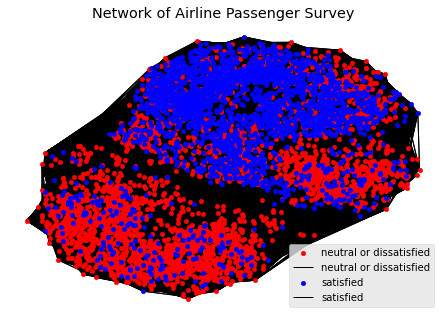

In [22]:
nx.draw(G,pos,nodelist=dissatisfied,node_size=20,node_color='r',label='neutral or dissatisfied')
nx.draw(G,pos,nodelist=satisfied,node_size=20,node_color='b',label='satisfied')
plt.title('Network of Airline Passenger Survey')
plt.legend()
plt.show()

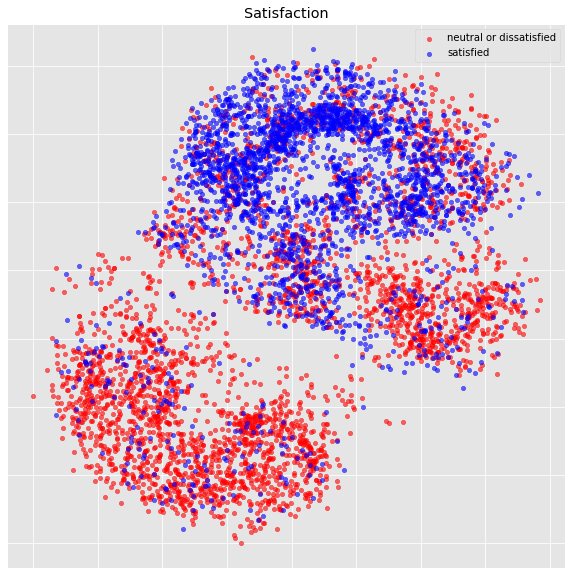

In [23]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.legend()
plt.title('Satisfaction')
plt.show()

<AxesSubplot:>

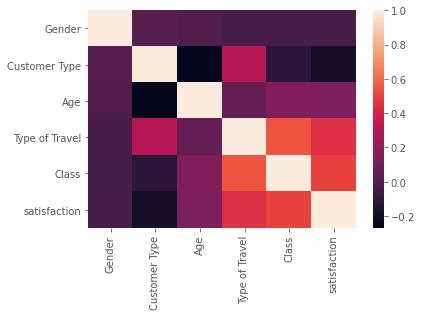

In [24]:
cormap_vars = X[['Gender','Customer Type','Age','Type of Travel','Class','satisfaction']]
cormap = cormap_vars.corr()
sns.heatmap(cormap)

In [25]:
male = df.index[df.Gender == 'Male'].tolist()
female = df.index[df.Gender == 'Female'].tolist()

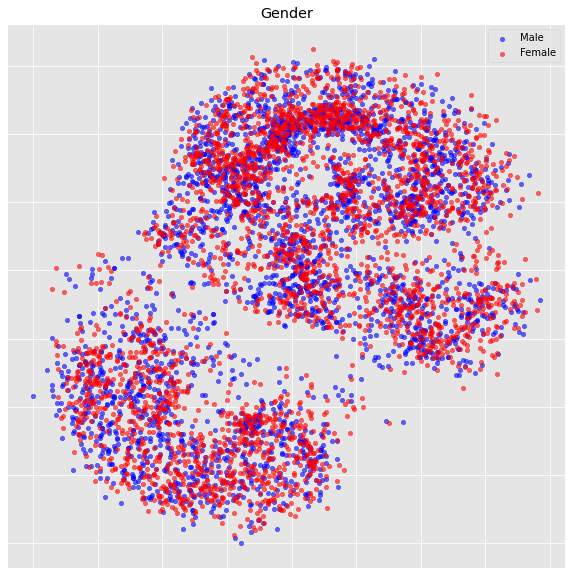

In [26]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.legend()
plt.title('Gender')
plt.show()

In [27]:
loyal = df.index[df['Customer Type'] == 'Loyal Customer'].tolist()
disloyal = df.index[df['Customer Type'] == 'disloyal Customer'].tolist()

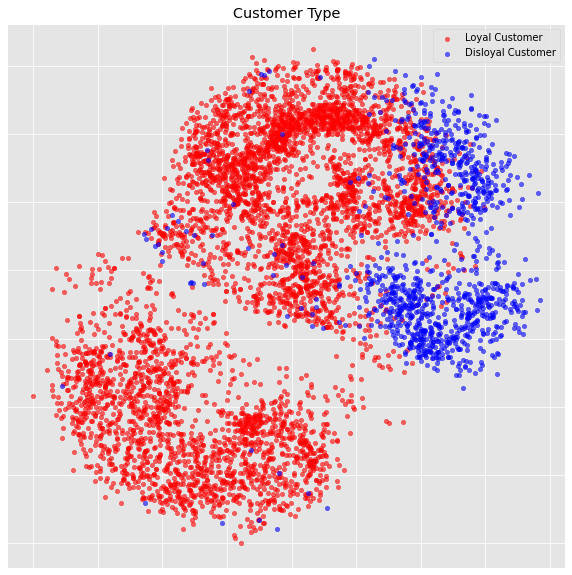

In [28]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.legend()
plt.title('Customer Type')
plt.show()

In [29]:
eco = df.index[df.Class == 'Eco'].tolist()
eco_plus = df.index[df.Class == 'Eco Plus'].tolist()
bus = df.index[df.Class == 'Business'].tolist()

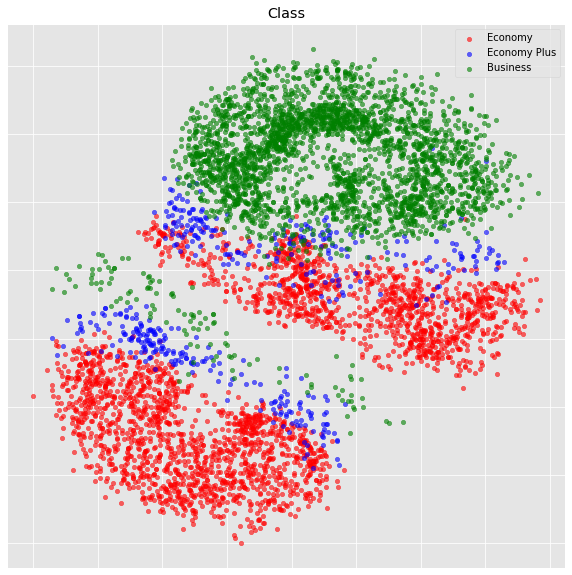

In [30]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.legend()
plt.title('Class')
plt.show()

In [31]:
personal = df.index[df['Type of Travel'] == 'Personal Travel'].tolist()
business = df.index[df['Type of Travel'] == 'Business travel'].tolist()

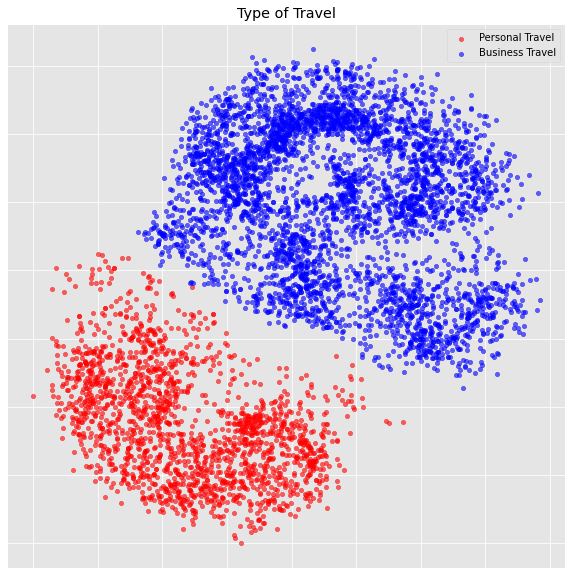

In [32]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.legend()
plt.title('Type of Travel')
plt.show()

In [33]:
AGE = df.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [34]:
age0 = AGE.index[AGE == 0].tolist()
age1 = AGE.index[AGE == 1].tolist()
age2 = AGE.index[AGE == 2].tolist()
age3 = AGE.index[AGE == 3].tolist()

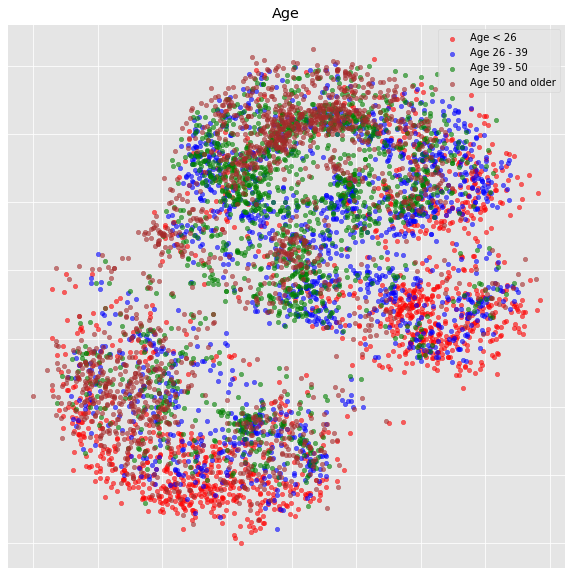

In [35]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older' )
plt.legend()
plt.title('Age')
plt.show()

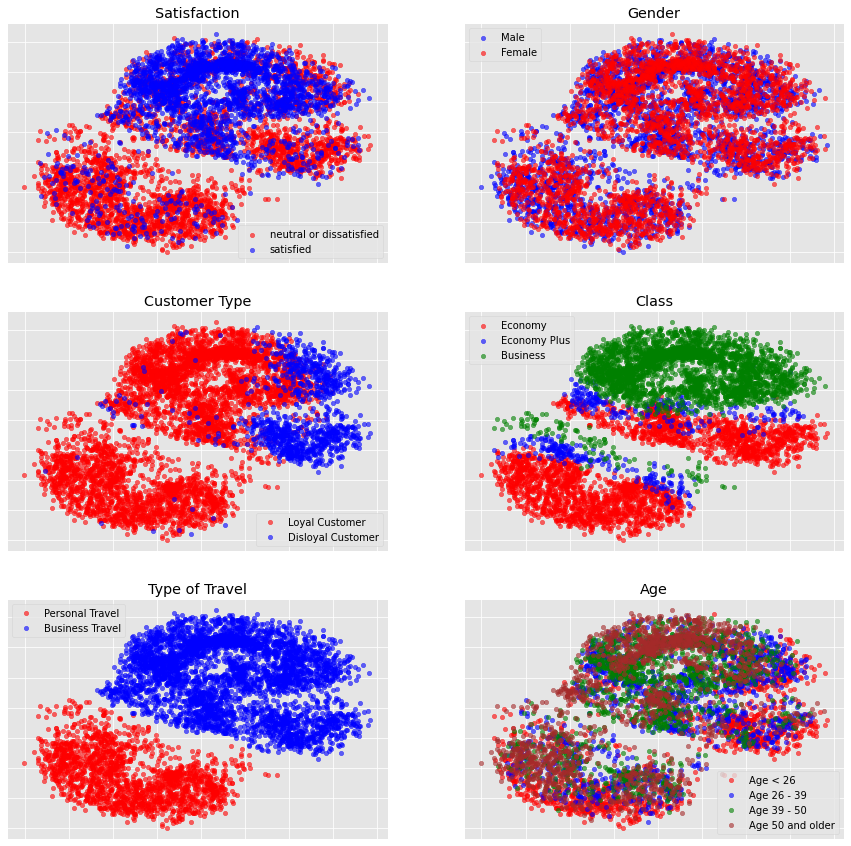

In [36]:
fig = plt.subplots(figsize=(15,15))

plt.subplot(321)
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.title('Satisfaction')
plt.legend()

plt.subplot(322)
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.title('Gender')
plt.legend()

plt.subplot(323)
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.title('Customer Type')
plt.legend()

plt.subplot(324)
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.title('Class')
plt.legend()

plt.subplot(325)
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.title('Type of Travel')
plt.legend()

plt.subplot(326)
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older')
plt.title('Age')
plt.legend()

plt.show()


In [20]:
G_dgl = dgl.from_networkx(G)

G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [21]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [109]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [110]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

In [111]:
len(train_nids)

4807

In [112]:
len(valid_nids)

1193

In [113]:
batch_size = 50
sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [114]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch)

[tensor([ 129, 3878, 4936,  ..., 5324, 1139, 5753]), tensor([ 129, 3878, 4936, 1950, 3481, 2243,  989, 3774, 1213, 2688, 4827, 3962,
         973, 4124, 2150,  643, 5361,   79, 3144, 5805, 2048, 3146, 1398, 2610,
         257, 5924, 2050, 5934, 1945, 1331,  125, 3970, 5812, 1946, 4365, 1447,
        5589, 3627, 3870,  616, 4139,  464, 2903, 1340, 3019, 4856, 3037, 5562,
        3195, 3405]), [Block(num_src_nodes=2456, num_dst_nodes=529, num_edges=2645), Block(num_src_nodes=529, num_dst_nodes=50, num_edges=500)]]


In [115]:
input_nodes, output_nodes, bipartites = example_minibatch
print("To compute {} nodes' output we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

To compute 50 nodes' output we need 2456 nodes' input features


In [116]:
print(bipartites)

[Block(num_src_nodes=2456, num_dst_nodes=529, num_edges=2645), Block(num_src_nodes=529, num_dst_nodes=50, num_edges=500)]


In [117]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [118]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [119]:
## Used for sum-pooling
class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            
        return x

In [120]:
model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
#model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type='lstm') #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)# GraphSage

In [121]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


Epoch: 0, Training Accuracy: 0.664, Training Loss: 0.604
Epoch: 0, Validation Accuracy: 0.700, Validation Loss: 0.558, Time: 1.9809
Epoch: 1, Training Accuracy: 0.713, Training Loss: 0.567
Epoch: 1, Validation Accuracy: 0.700, Validation Loss: 0.554, Time: 1.8183
Epoch: 2, Training Accuracy: 0.731, Training Loss: 0.544
Epoch: 2, Validation Accuracy: 0.752, Validation Loss: 0.526, Time: 2.0711
Epoch: 3, Training Accuracy: 0.769, Training Loss: 0.508
Epoch: 3, Validation Accuracy: 0.768, Validation Loss: 0.478, Time: 1.9590
Epoch: 4, Training Accuracy: 0.803, Training Loss: 0.459
Epoch: 4, Validation Accuracy: 0.791, Validation Loss: 0.453, Time: 2.0331
Epoch: 5, Training Accuracy: 0.825, Training Loss: 0.430
Epoch: 5, Validation Accuracy: 0.844, Validation Loss: 0.411, Time: 2.0245
Epoch: 6, Training Accuracy: 0.843, Training Loss: 0.395
Epoch: 6, Validation Accuracy: 0.824, Validation Loss: 0.416, Time: 2.0064
Epoch: 7, Training Accuracy: 0.843, Training Loss: 0.395
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.915, Training Loss: 0.215
Epoch: 62, Validation Accuracy: 0.930, Validation Loss: 0.178, Time: 1.9224
Epoch: 63, Training Accuracy: 0.914, Training Loss: 0.208
Epoch: 63, Validation Accuracy: 0.898, Validation Loss: 0.233, Time: 1.9989
Epoch: 64, Training Accuracy: 0.913, Training Loss: 0.220
Epoch: 64, Validation Accuracy: 0.930, Validation Loss: 0.174, Time: 2.0035
Epoch: 65, Training Accuracy: 0.910, Training Loss: 0.212
Epoch: 65, Validation Accuracy: 0.935, Validation Loss: 0.169, Time: 2.0000
Epoch: 66, Training Accuracy: 0.917, Training Loss: 0.204
Epoch: 66, Validation Accuracy: 0.935, Validation Loss: 0.175, Time: 1.9997
Epoch: 67, Training Accuracy: 0.918, Training Loss: 0.206
Epoch: 67, Validation Accuracy: 0.933, Validation Loss: 0.166, Time: 1.9965
Epoch: 68, Training Accuracy: 0.921, Training Loss: 0.204
Epoch: 68, Validation Accuracy: 0.939, Validation Loss: 0.158, Time: 1.9935
Epoch: 69, Training Accuracy: 0.919, Training Loss: 0.203
Epoc

Epoch: 123, Training Accuracy: 0.938, Training Loss: 0.165
Epoch: 123, Validation Accuracy: 0.935, Validation Loss: 0.156, Time: 1.8487
Epoch: 124, Training Accuracy: 0.933, Training Loss: 0.166
Epoch: 124, Validation Accuracy: 0.950, Validation Loss: 0.138, Time: 1.8460
Epoch: 125, Training Accuracy: 0.938, Training Loss: 0.167
Epoch: 125, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.8437
Epoch: 126, Training Accuracy: 0.940, Training Loss: 0.154
Epoch: 126, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.8422
Epoch: 127, Training Accuracy: 0.934, Training Loss: 0.164
Epoch: 127, Validation Accuracy: 0.949, Validation Loss: 0.125, Time: 1.8409
Epoch: 128, Training Accuracy: 0.934, Training Loss: 0.160
Epoch: 128, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.8402
Epoch: 129, Training Accuracy: 0.934, Training Loss: 0.159
Epoch: 129, Validation Accuracy: 0.943, Validation Loss: 0.153, Time: 1.8390
Epoch: 130, Training Accuracy: 0.939, Training L

Epoch: 183, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.9736
Epoch: 184, Training Accuracy: 0.943, Training Loss: 0.144
Epoch: 184, Validation Accuracy: 0.954, Validation Loss: 0.123, Time: 1.9841
Epoch: 185, Training Accuracy: 0.940, Training Loss: 0.153
Epoch: 185, Validation Accuracy: 0.948, Validation Loss: 0.141, Time: 1.9875
Epoch: 186, Training Accuracy: 0.931, Training Loss: 0.170
Epoch: 186, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.9935
Epoch: 187, Training Accuracy: 0.938, Training Loss: 0.153
Epoch: 187, Validation Accuracy: 0.948, Validation Loss: 0.137, Time: 1.9958
Epoch: 188, Training Accuracy: 0.940, Training Loss: 0.147
Epoch: 188, Validation Accuracy: 0.953, Validation Loss: 0.128, Time: 1.9969
Epoch: 189, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 189, Validation Accuracy: 0.946, Validation Loss: 0.142, Time: 1.9993
Epoch: 190, Training Accuracy: 0.938, Training Loss: 0.148
Epoch: 190, Validation Accuracy: 0.950, Validati

Epoch: 244, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 244, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.9778
Epoch: 245, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 245, Validation Accuracy: 0.956, Validation Loss: 0.125, Time: 1.9783
Epoch: 246, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 246, Validation Accuracy: 0.954, Validation Loss: 0.122, Time: 1.9766
Epoch: 247, Training Accuracy: 0.944, Training Loss: 0.148
Epoch: 247, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.9765
Epoch: 248, Training Accuracy: 0.943, Training Loss: 0.135
Epoch: 248, Validation Accuracy: 0.953, Validation Loss: 0.119, Time: 1.9825
Epoch: 249, Training Accuracy: 0.944, Training Loss: 0.146
Epoch: 249, Validation Accuracy: 0.951, Validation Loss: 0.115, Time: 1.9866
Epoch: 250, Training Accuracy: 0.940, Training Loss: 0.142
Epoch: 250, Validation Accuracy: 0.955, Validation Loss: 0.120, Time: 1.9848
Epoch: 251, Training Accuracy: 0.948, Training L

Epoch: 305, Training Accuracy: 0.946, Training Loss: 0.139
Epoch: 305, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 1.9153
Epoch: 306, Training Accuracy: 0.944, Training Loss: 0.140
Epoch: 306, Validation Accuracy: 0.955, Validation Loss: 0.119, Time: 1.9136
Epoch: 307, Training Accuracy: 0.946, Training Loss: 0.141
Epoch: 307, Validation Accuracy: 0.949, Validation Loss: 0.118, Time: 1.9116
Epoch: 308, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 308, Validation Accuracy: 0.952, Validation Loss: 0.120, Time: 1.9096
Epoch: 309, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 309, Validation Accuracy: 0.946, Validation Loss: 0.142, Time: 1.9075
Epoch: 310, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 310, Validation Accuracy: 0.951, Validation Loss: 0.124, Time: 1.9054
Epoch: 311, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 311, Validation Accuracy: 0.954, Validation Loss: 0.115, Time: 1.9035
Epoch: 312, Training Accuracy: 0.945, Training L

Epoch: 366, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 366, Validation Accuracy: 0.951, Validation Loss: 0.120, Time: 1.8468
Epoch: 367, Training Accuracy: 0.944, Training Loss: 0.138
Epoch: 367, Validation Accuracy: 0.901, Validation Loss: 0.237, Time: 1.8456
Epoch: 368, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 368, Validation Accuracy: 0.950, Validation Loss: 0.127, Time: 1.8444
Epoch: 369, Training Accuracy: 0.942, Training Loss: 0.133
Epoch: 369, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.8428
Epoch: 370, Training Accuracy: 0.947, Training Loss: 0.132
Epoch: 370, Validation Accuracy: 0.951, Validation Loss: 0.118, Time: 1.8430
Epoch: 371, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 371, Validation Accuracy: 0.954, Validation Loss: 0.124, Time: 1.8425
Epoch: 372, Training Accuracy: 0.950, Training Loss: 0.132
Epoch: 372, Validation Accuracy: 0.942, Validation Loss: 0.148, Time: 1.8446
Epoch: 373, Training Accuracy: 0.948, Training L

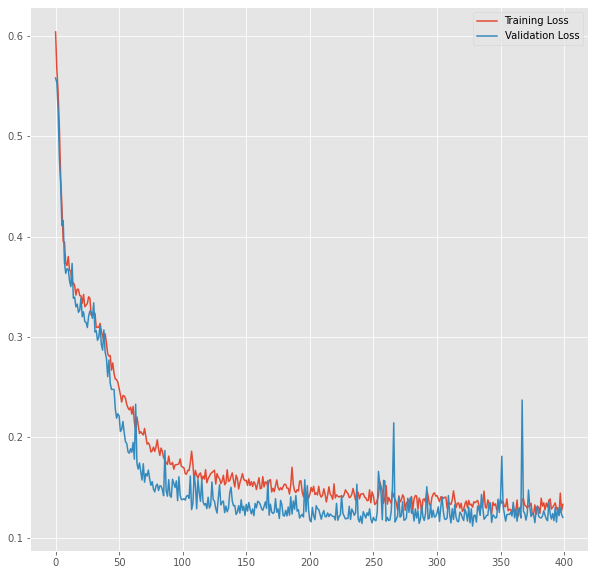

In [122]:
plt.figure(figsize=(10,10))
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

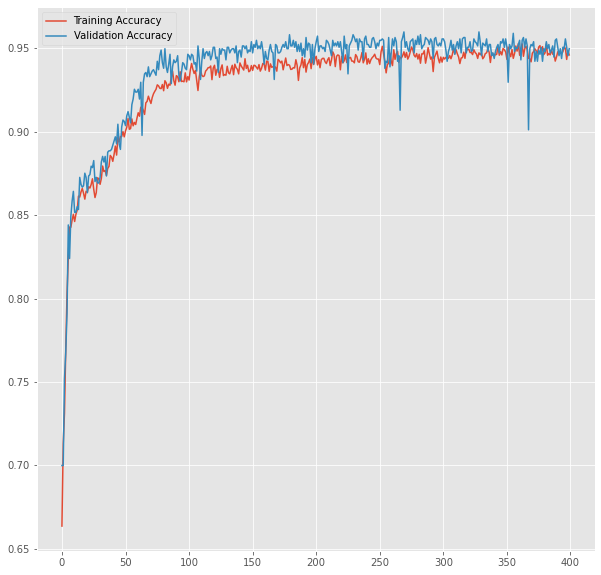

In [123]:
plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [124]:
print('Training Accuracy: {}'.format(train_acc[-1]))
print('Validation Accuracy: {}'.format(valid_acc[-1]))

Training Accuracy: 0.945949926362297
Validation Accuracy: 0.9497066219614417


In [125]:
np.argmax(valid_acc)

269

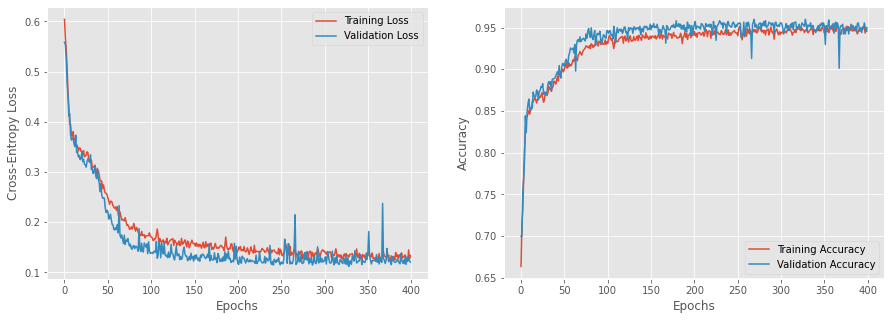

In [126]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [127]:
model.parameters

<bound method Module.parameters of SumSAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=24, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)>

In [155]:
G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.3)
G_dgl.ndata['label'] = torch.tensor(features)

G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [156]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.pytorch.conv.GraphConv(
            in_feats=in_feats, out_feats=hid_feats,norm='both', weight=True, bias=True, activation=nn.ReLU(inplace=False))
        
        self.conv2 = dglnn.pytorch.conv.GraphConv(
            in_feats=hid_feats, out_feats=out_feats,norm='both', weight=True, bias=True, activation=nn.LogSoftmax(dim=1))
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.conv2(graph, h)
        return h

In [172]:
model_gcn = GCN(n_features, len(x_wd.T) , n_labels) # 
opt = torch.optim.Adam(model_gcn.parameters(),lr=0.002)#GCN

In [173]:
def evaluate(model_gcn, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model_gcn(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        preds = F.log_softmax(logits,dim=1)
        _, indices = torch.max(preds, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [174]:
#model = GCN(in_feats=n_features, hid_feats_1=128, hid_feats_2=128, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters(),lr=1e-2)
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(1000):
    t0 = time.time()
    model_gcn.train()
    # forward propagation by using all nodes
    logits = model_gcn(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    acc_train = evaluate(model_gcn, G_dgl, node_features, node_labels, train_mask)
    train_acc.append(acc_train)
    plot_loss_train.append(loss_train.item())
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    
    model.eval()
    
    # compute validation accuracy
    with torch.no_grad():
        acc_val = evaluate(model_gcn, G_dgl, node_features, node_labels, valid_mask)
        loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
        valid_acc.append(acc_val)
        plot_loss_val.append(loss_val.item())
    # backward propagation
    
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


Epoch: 0, train loss: 0.7144, validation loss: 0.7109, training accuracy: 0.4233, validation accuracy: 0.5679, Time: 0.8020
Epoch: 10, train loss: 0.6750, validation loss: 0.6753, training accuracy: 0.5700, validation accuracy: 0.5679, Time: 0.7475
Epoch: 20, train loss: 0.6633, validation loss: 0.6635, training accuracy: 0.7251, validation accuracy: 0.7501, Time: 0.7809
Epoch: 30, train loss: 0.6493, validation loss: 0.6504, training accuracy: 0.5767, validation accuracy: 0.5710, Time: 0.7281
Epoch: 40, train loss: 0.6370, validation loss: 0.6382, training accuracy: 0.5767, validation accuracy: 0.5707, Time: 0.6672
Epoch: 50, train loss: 0.6248, validation loss: 0.6257, training accuracy: 0.6116, validation accuracy: 0.7560, Time: 0.6266
Epoch: 60, train loss: 0.6127, validation loss: 0.6133, training accuracy: 0.7577, validation accuracy: 0.7726, Time: 0.6080
Epoch: 70, train loss: 0.6010, validation loss: 0.6012, training accuracy: 0.7572, validation accuracy: 0.7711, Time: 0.5749
E

Epoch: 660, train loss: 0.5014, validation loss: 0.4922, training accuracy: 0.7589, validation accuracy: 0.7669, Time: 0.5800
Epoch: 670, train loss: 0.5013, validation loss: 0.4920, training accuracy: 0.7589, validation accuracy: 0.7671, Time: 0.5756
Epoch: 680, train loss: 0.5012, validation loss: 0.4918, training accuracy: 0.7589, validation accuracy: 0.7671, Time: 0.5718
Epoch: 690, train loss: 0.5010, validation loss: 0.4918, training accuracy: 0.7589, validation accuracy: 0.7674, Time: 0.5711
Epoch: 700, train loss: 0.5009, validation loss: 0.4914, training accuracy: 0.7589, validation accuracy: 0.7674, Time: 0.5705
Epoch: 710, train loss: 0.5008, validation loss: 0.4913, training accuracy: 0.7594, validation accuracy: 0.7674, Time: 0.5700
Epoch: 720, train loss: 0.5007, validation loss: 0.4908, training accuracy: 0.7589, validation accuracy: 0.7676, Time: 0.5718
Epoch: 730, train loss: 0.5006, validation loss: 0.4909, training accuracy: 0.7594, validation accuracy: 0.7674, Time:

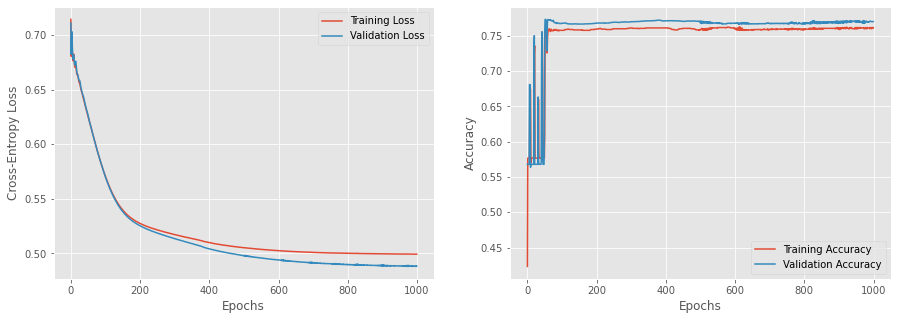

In [175]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(plot_loss_train,label='Training Loss')
plt.plot(plot_loss_val,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [176]:
val_tens = torch.tensor(features)
_, indices_val = torch.max(logits[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logits[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


Classification Accuracy validation set 0.7699597251836058
-------------------------------------------------------------
Classification Accuracy training set 0.761663856098932
-------------------------------------------------------------
Confusion Matrix validation set:
[[1866  531]
 [ 440 1384]]
-------------------------------------------------------------
Confusion Matrix training set:
[[793 233]
 [191 562]]


In [177]:
model_gcn.parameters

<bound method Module.parameters of GCN(
  (conv1): GraphConv(
    in=24, out=24, normalization=both
    (_activation): ReLU()
  )
  (conv2): GraphConv(
    in=24, out=2, normalization=both
    (_activation): LogSoftmax(dim=1)
  )
)>

In [42]:
# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])

# customer type (loyal vs disoyal)

type_alpha0 = 0.8
type_beta1 = 0.5

aff_type = np.array([[type_alpha0, type_beta1],
                     [type_beta1, type_alpha0]])


# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta3,age_beta2,age_beta1,age_alpha0]])


# Type of travel
trav_type_alpha0 = 0.80
trav_type_beta1 = 0.20

aff_trav_type = np.array([[trav_type_alpha0, trav_type_beta1],
                          [trav_type_beta1, trav_type_alpha0]])

# Class

class_alpha0 = 0.85
class_beta1 = 0.60
class_beta2 = 0.40

aff_class = np.array([[class_alpha0, class_beta1, class_beta2],
                      [class_beta1, class_alpha0, class_beta1],
                      [class_beta2, class_beta1, class_alpha0]])


aff = {0:aff_gend, 1:aff_type, 2:aff_age, 3:aff_trav_type, 4:aff_class}

In [43]:
x = test_gen.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [44]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0

In [45]:
A = A + A.T

In [46]:
G_test = nx.from_numpy_matrix(A)

In [47]:
test_features = pd.Series(TEST.satisfaction)

In [48]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = TEST.drop(columns=['satisfaction'])
feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl_test.ndata['feat'] =  torch.tensor(feat_test.values,dtype=torch.float)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [148]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [149]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

In [150]:
model.load_state_dict(torch.load('model.pt'))
all_logits = inference(model, G_dgl_test, node_features, 6000)

100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


In [151]:
test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.9421666666666667


In [152]:
print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

Classification Accuracy test set 0.9421666666666667
-------------------------------------------------------------
Confusion Matrix test set:
[[3236  130]
 [ 217 2417]]


In [153]:
sklearn.metrics.f1_score(test_labels.numpy(),test_predictions.numpy(),average='micro')

0.9421666666666667

In [154]:
test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
test_loss

array(0.14645189, dtype=float32)

In [108]:
model.layers

ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (activation): ReLU()
    (lstm): LSTM(24, 24, batch_first=True)
    (fc_self): Linear(in_features=24, out_features=24, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
  )
  (1): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (lstm): LSTM(24, 24, batch_first=True)
    (fc_self): Linear(in_features=24, out_features=2, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
  )
)

In [ ]:
f = pd.get_dummies(features)
x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
#model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
#model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=250, batch_size=10)

In [ ]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [ ]:
yy_test = pd.get_dummies(yy)
results = model.evaluate(xx_dummy, yy_test, batch_size=128)
#y_hat = model.predict_classes(xx_dummy, verbose=1)
#y_hat_dummy = pd.get_dummies(y_hat)
print("test loss, test acc:", results)
#print(sklearn.metrics.f1_score(y_hat_dummy, yy_test,average='micro'))

In [ ]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)


clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

In [ ]:
svm_y_test = np.empty((len(yy),1))

for i in range(len(yy)):
    if yy.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [ ]:
y_pred = clf.predict(xx_dummy)
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

In [ ]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.title('Degree Distribution')
    plt.xlabel('Degrees')
    plt.ylabel('Number of Nodes')
    plt.show()
    
plot_degree_dist(G)

In [ ]:
G.number_of_edges()

In [ ]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)

clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

In [ ]:
y_pred = clf.predict(xx_dummy)
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

In [ ]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

In [ ]:
clf = QDA()
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, svm_y_test))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_wd,features, test_size = 0.2, shuffle=True)
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, yy))